# Curve-fitting with PyTorch

We consider an exponential function

$$
   y = a \mathrm{e}^{-k x} + b
$$

and suppose that we only have noisy observations of

$$ y + \eta , $$

where $\eta$ is a zero-mean Gaussian noise with given variance.


## Objective

The objective is to learn the three unknown parameters, $a,$ $b$ and $k$ from the known, noisy observations of $y.$ To do this we will minimize a mean-squared loss function, just as is done in simple linear regression. 

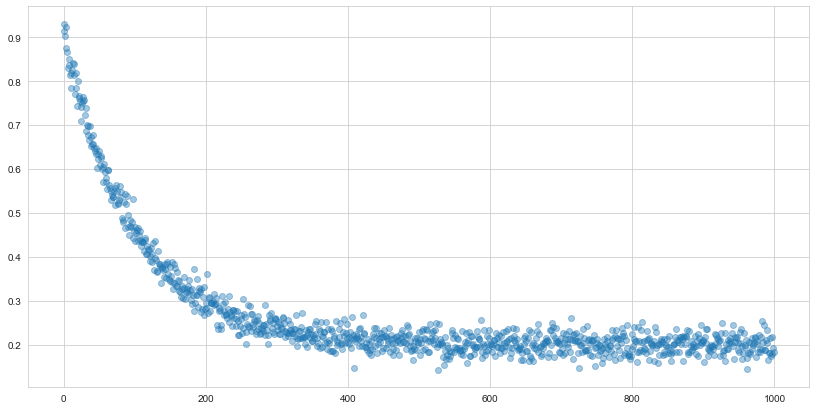

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
import seaborn as sns
sns.set_style("whitegrid")

# Observations
n = 1000
noise = torch.Tensor(np.random.normal(0, 0.02, size=n))
x = torch.arange(n)
a, k, b = 0.7, .01, 0.2
y = a * np.exp(-k * x) + b + noise
plt.figure(figsize=(14, 7))
plt.scatter(x, y, alpha=0.4)
plt.show()

Define the model and the training loop.

In [2]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        a, k, b = self.weights
        return a * torch.exp(-k * X) + b
    
def training_loop(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        preds = model(x)
        loss = F.mse_loss(preds, y).sqrt()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())  
    return losses

We have defined the weights and manually registered them as parameters.

By calling `nn.Parameter` the weights we have defined will behave and function in the same way as standard Pytorch parameters — i.e they can calculate gradients and be updated in response to a loss function. The training loop is simply iterating over `n` epochs, each time estimating the mean squared error and updating the gradients.

We can now run the model. We wil use Adam for the optimization, with a small learning rate.


Parameter containing:
tensor([0.6892, 0.0098, 0.2005], requires_grad=True)


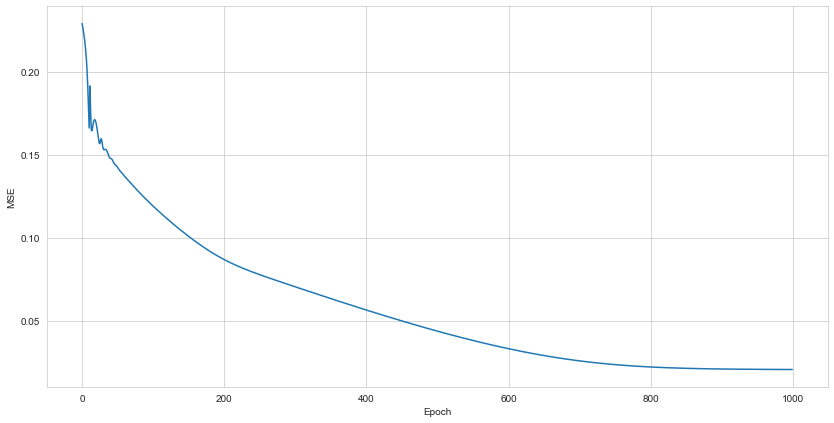

In [4]:
# instantiate model
m = Model()
# Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=0.001)
losses = training_loop(m, opt)
plt.figure(figsize=(14, 7))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
print(m.weights)

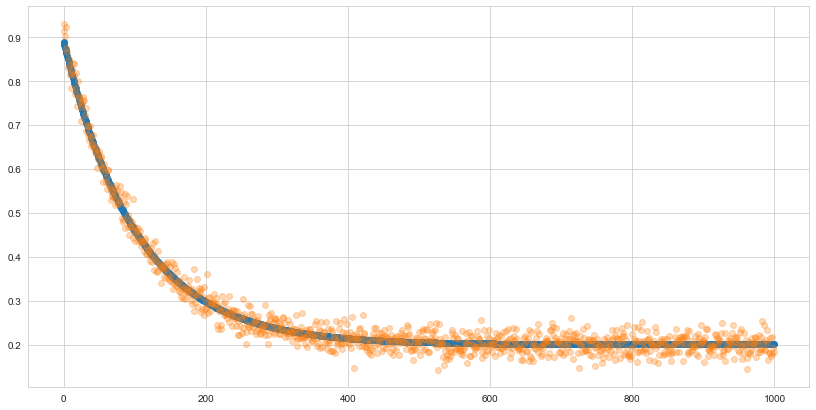

In [5]:
preds = m(x)
plt.figure(figsize=(14, 7))
plt.scatter(x, preds.detach().numpy())
plt.scatter(x, y, alpha=.3)
plt.show()